In [ ]:
### Using Transfer learning to recognise object and

#  Depth Estimation using Intel's weight

In [4]:
pip install matplotlib opencv-python torch numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [14]:
!pip install transformers
!pip install ipywidgets
!pip install scipy
!pip install ipywidgets tqdm



In [2]:
!pip install transformers
!pip install scipy
!pip install torch torchvision
!pip install matplotlib
!pip install pillow


In [18]:
from transformers import DPTImageProcessor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

ModuleNotFoundError: Could not import module 'DPTForDepthEstimation'. Are this object's requirements defined correctly?

In [3]:
image_path = r"dog.png"
image = Image.open(image_path)


In [4]:
processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
inputs = processor(images=image, return_tensors="pt")

In [5]:
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

In [6]:
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [7]:
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

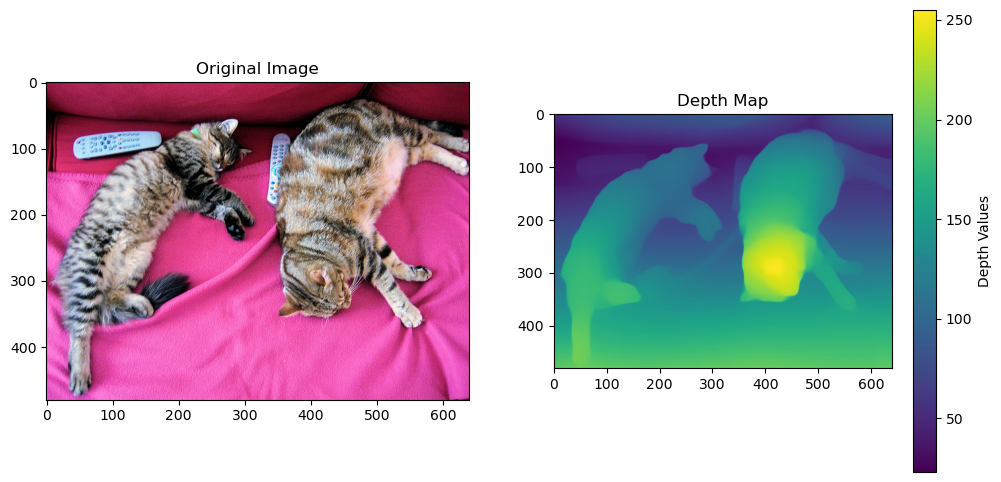

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image)
axs[0].set_title('Original Image')

depth_plot = axs[1].imshow(depth, cmap='viridis')  
axs[1].set_title('Depth Map')
plt.colorbar(depth_plot, ax=axs[1], orientation='vertical', label='Depth Values')


plt.show()

In [6]:
import scipy
print(scipy.__version__)


1.14.1


# Intel's deep learning model

In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import DPTImageProcessor, DPTForDepthEstimation

def analyzer(frame, model, processor):
    inputs = processor(images=frame, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth
    
        height, width = frame.shape[:2]  
        
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=(height, width),  
            mode="bicubic",
            align_corners=False,
        )
    
        output = prediction.squeeze().cpu().numpy()
        formatted = (output * 255 / np.max(output)).astype("uint8")
        depth = Image.fromarray(formatted)

        return depth  

processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

cap = cv2.VideoCapture(0)

while True:
 
    ret, frame = cap.read()
    
    if not ret:
        print("Failed to capture frame")
        break
    
    depth_map = analyzer(frame, model, processor)

    
    cv2.imshow('depth', np.array(depth_map))  
    
    if cv2.waitKey(1) & 0xFF == 27:
        break
        
cap.release()
cv2.destroyAllWindows()


# Depth using comparision


In [ ]:

import cv2
def FocalLength(measured_distance, real_width, width_in_rf_image):
    focal_length = (width_in_rf_image* measured_distance)/ real_width
    return focal_length

def Distance_finder (Focal_Length, real_face_width, face_width_in_frame):
    distance = (real_face_width * Focal_Length)/face_width_in_frame
    return distance

face_detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

def face_data(image):
    face_width = 0 
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray_image, 1.3, 5)
    for (x, y, h, w) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (222,141,123), 1)
        face_width = w

    return face_width

In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)

def empty(a):
    pass


def resize_final_img(x,y,*argv):
    images  = cv2.resize(argv[0], (x, y))
    for i in argv[1:]:
        resize = cv2.resize(i, (x, y))
        images = np.concatenate((images,resize),axis = 1)
    return images

cv2.namedWindow("HSV")
cv2.resizeWindow("HSV", 300, 300)
cv2.createTrackbar("HUE Min", "HSV", 0, 179, empty)
cv2.createTrackbar("HUE Max", "HSV", 179, 179, empty)
cv2.createTrackbar("SAT Min", "HSV", 0, 255, empty)
cv2.createTrackbar("SAT Max", "HSV", 255, 255, empty)
cv2.createTrackbar("VALUE Min", "HSV", 0, 255, empty)
cv2.createTrackbar("VALUE Max", "HSV", 255, 255, empty)


cv2.resizeWindow('F', 700,600)


while True:
    ret, img = cap.read()
    h_min = cv2.getTrackbarPos("HUE Min", "HSV")
    h_max = cv2.getTrackbarPos("HUE Max", "HSV")
    s_min = cv2.getTrackbarPos("SAT Min", "HSV")
    s_max = cv2.getTrackbarPos("SAT Max", "HSV")
    v_min = cv2.getTrackbarPos("VALUE Min", "HSV")
    v_max = cv2.getTrackbarPos("VALUE Max", "HSV")

    hsv_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

    lower = np.array([h_min, s_min, v_min])
    upper = np.array([h_max, s_max, v_max])
    mask = cv2.inRange(hsv_img, lower, upper)
    kernel = np.ones((3,3),'uint8')

    
    d_img = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel,iterations = 5)

    final_img = resize_final_img(300,300, mask, d_img)
    # final_img = np.concatenate((mask,d_img,e_img),axis =1)
    cv2.imshow('F',final_img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

In [3]:
import cv2 
import pyttsx3

previous_distance = 80 

width =20 

language = 'en'
# Initialize the text-to-speech engine
engine = pyttsx3.init()

# Set properties (optional)
engine.setProperty('rate', 150)  # Speed of speech


# to compare the distance we will add another image 
img = cv2.imread("WhatsApp Image 2023-10-18 at 23.14.49.jpeg")
face_width = face_data(img)
Focal_length = FocalLength(previous_distance, width,face_width)

video = cv2.VideoCapture(0)
while True:
    ret, frame = video.read()
    if ret==True:
        face_width_in_frame = face_data(frame)
        if face_width_in_frame !=0:
            Distance = round(Distance_finder(Focal_length, width,face_width_in_frame),2)
            cv2.putText(frame, "Distance from Camera "+"{}".format(Distance)+"CM", (50,50), cv2.FONT_HERSHEY_COMPLEX,1, (123,246,123),3)
            engine.say("Distance from camera is {} centimeters".format(Distance))
            engine.runAndWait()
        cv2.imshow("frame", frame )
        if cv2.waitKey(1)== 27:
            break 
video.release()
cv2.destroyAllWindows()

objc[79438]: class `NSKVONotifying_AVCaptureConnection' not linked into application
objc[79438]: class `NSKVONotifying_AVCaptureVideoDataOutput' not linked into application
objc[79438]: class `NSKVONotifying_AVCaptureInputPort' not linked into application
objc[79438]: class `NSKVONotifying_AVCaptureDeviceInput' not linked into application


NameError: name 'objc' is not defined

In [8]:
import pyttsx3

# Initialize the text-to-speech engine
engine = pyttsx3.init(driverName='nsss')

# Set properties (optional)
engine.setProperty('rate', 150)  # Speed of speech

engine.say("hii how are you")
engine.runAndWait()


NameError: name 'objc' is not defined

In [7]:
pip install --upgrade pyttsx3


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python-headless
pip install pytesseract
pip install gTTS


SyntaxError: invalid syntax (1851347612.py, line 1)

In [4]:
pip install opencv-python-headless
pip install pytesseract
pip install gTTS


SyntaxError: invalid syntax (1851347612.py, line 1)

In [ ]:
pip install opencv-python-headless

  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/12/0f/b87324db284c54d1d1a1c1242a128fb18515915d124325784c90f23d8ef5/opencv_python_headless-4.8.1.78-cp37-abi3-macosx_11_0_arm64.whl.metadata
   ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.5/33.1 MB 20.5 kB/s eta 0:26:37

In [1]:
pip install pytesseract

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install gTTS

In [ ]:
import cv2
import pytesseract
import pyttsx3
from gtts import gTTS
import os
from pydub import AudioSegment
from pydub.playback import play

# Initialize the webcam (adjust the camera index as needed)
cap = cv2.VideoCapture(0)

# Initialize text-to-speech engine
text_to_speech_engine = pyttsx3.init()

while True:
    # Capture a frame from the webcam
    ret, frame = cap.read()

    # Perform text recognition using pytesseract
    recognized_text = pytesseract.image_to_string(frame)

    # Display the recognized text on the frame
    cv2.putText(frame, recognized_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame with recognized text
    cv2.imshow('Live Text Recognition', frame)

    # Convert the recognized text to speech
    speech = gTTS(text=recognized_text, lang='en')

    # Save the speech to an audio file
    speech.save('output_speech.mp3')

    # Play the generated speech using pydub (optional)
    audio = AudioSegment.from_mp3('output_speech.mp3')
    play(audio)

    # Read the recognized text aloud using pyttsx3
    text_to_speech_engine.say(recognized_text)
    text_to_speech_engine.runAndWait()

    # Exit the loop when the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and destroy all OpenCV windows
cap.release()
cv2.destroyAllWindows()


In [3]:
pip install pydub


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pyttsx3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.6/738.6 kB 8.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.2/391.2 kB 22.3 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: pyobjc-core


    Found existing installation: pyobjc-core 9.0
    Uninstalling pyobjc-core-9.0:
      Successfully uninstalled pyobjc-core-9.0
  Attempting uninstall: pyobjc-framework-Cocoa
    Found existing installation: pyobjc-framework-Cocoa 9.0
    Uninstalling pyobjc-framework-Cocoa-9.0:
      Successfully uninstalled pyobjc-framework-Cocoa-9.0
  Attempting uninstall: pyobjc-framework-FSEvents
    Found existing installation: pyobjc-framework-FSEvents 9.0
    Uninstalling pyobjc-framework-FSEvents-9.0:
      Successfully uninstalled pyobjc-framework-FSEvents-9.0
  Attempting uninstall: pyobjc-framework-CoreServices
    Found existing installation: pyobjc-framework-CoreServices 9.0
    Uninstalling pyobjc-framework-CoreServices-9.0:
      Successfully uninstalled pyobjc-framework-CoreServices-9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.4.3 requires pyq

In [1]:
import cv2
import pytesseract
import pyttsx3
from gtts import gTTS
import os
from pydub import AudioSegment
from pydub.playback import play

# Initialize the webcam (adjust the camera index as needed)
cap = cv2.VideoCapture(0)

# Initialize text-to-speech engine
text_to_speech_engine = pyttsx3.init()

while True:
    # Capture a frame from the webcam
    ret, frame = cap.read()

    # Perform text recognition using pytesseract
    recognized_text = pytesseract.image_to_string(frame)

    # Display the recognized text on the frame
    cv2.putText(frame, recognized_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame with recognized text
    cv2.imshow('Live Text Recognition', frame)

    # Convert the recognized text to speech
    speech = gTTS(text=recognized_text, lang='en')

    # Save the speech to an audio file
    speech.save('output_speech.mp3')

    # Play the generated speech using pydub (optional)
    audio = AudioSegment.from_mp3('output_speech.mp3')
    play(audio)

    # Read the recognized text aloud using pyttsx3
    text_to_speech_engine.say(recognized_text)
    text_to_speech_engine.runAndWait()

    # Exit the loop when the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and destroy all OpenCV windows
cap.release()
cv2.destroyAllWindows()

/Users/samradny/anaconda3/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
objc[9133]: class `NSKVONotifying_AVCaptureConnection' not linked into application
objc[9133]: class `NSKVONotifying_AVCaptureVideoDataOutput' not linked into application
objc[9133]: class `NSKVONotifying_AVCaptureInputPort' not linked into application
objc[9133]: class `NSKVONotifying_AVCaptureDeviceInput' not linked into application


NameError: name 'objc' is not defined

In [2]:
conda create --name pyttsx3-env python=3.x



SyntaxError: invalid decimal literal (2147336290.py, line 1)

In [3]:
conda create --name pyttsx3-env python=3.x
conda activate pyttsx3-env
pip install pyttsx3


SyntaxError: invalid decimal literal (3036690487.py, line 1)

In [ ]:
conda create --name pyttsx3-env python=3.11.4

Solving environment: unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.5.2
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.9.0



## Package Plan ##

  environment location: /Users/samradny/anaconda3/envs/pyttsx3-env

  added / updated specs:
    - python=3.11.4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libsqlite-3.43.2           |       h091b4b1_0         790 KB  conda-forge
    pip-23.3.1                 |     pyhd8ed1ab_0         1.3 MB  conda-forge
    python-3.11.4              |h47c9636_0_cpython        14.0 MB  conda-forge
    -----------------------------------------------

In [ ]:
conda create --name pyttsx3-env python=3.11.4


Retrieving notices: ...working... done
Solving environment: unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.9.0



## Package Plan ##

  environment location: /Applications/anaconda3/envs/pyttsx3-env

  added / updated specs:
    - python=3.11.4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bzip2-1.0.8                |       h3422bc3_4         148 KB  conda-forge
    ca-certificates-2023.7.22  |       hf0a4a13_0         146 KB  conda-forge
    libexpat-2.5.0             |       hb7217d7_1          62 KB  conda-forge
    libffi-3.4.

In [ ]:

xpip install opencv-python

In [ ]:
pip install opencv-pythonx